#BLOOD CELL TYPE CLASSIFICATION

Hello! we built 2 model that recognize different types of normal peripheral blood cells that grouped in 8 class : neutrophils, eosinophils, basophils, lymphocytes, monocytes, immature granulocytes (promyelocytes, myelocytes, and metamyelocytes), erythroblasts and platelets or thrombocytes.

This file contains an CNN with ResNet50 and CNN alone.

Dataset : https://www.kaggle.com/datasets/unclesamulus/blood-cells-image-dataset/data

###Import Library

In [ ]:
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import keras.applications.xception as xception
import zipfile
import sys
import time
import tensorflow.keras as keras
import tensorflow as tf
import re
import PIL
from PIL import Image
from tensorflow.keras.preprocessing import image_dataset_from_directory, image
from keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, Lambda, Dropout
from keras.layers.experimental.preprocessing import Normalization
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50

###Kaggle Setting

Installing the Kaggle API client, uploading json files containing Kaggle API key, and downloading dataset to Google Colab environment.

In [ ]:
!pip install -q kaggle
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle (1).json


In [ ]:
!chmod 600 /content/kaggle.json

In [ ]:
! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d unclesamulus/blood-cells-image-dataset

blood-cells-image-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


###Load Data

Unzip and load the image dataset into spesific direcrory (dataset_dir)

In [ ]:
blood_zip = '/content/blood-cells-image-dataset.zip'
zip_temp = zipfile.ZipFile(blood_zip, 'r')
zip_temp.extractall('/content')
zip_temp.close()

In [ ]:
dataset_dir = '/content/bloodcells_dataset/'

###Data Exploration

Counting total files in every folder with count_files function

In [ ]:
def count_files(start_path):
    total_files = 0

    for current_path, directories, files in os.walk(start_path):
        depth = current_path.replace(start_path, '').count(os.sep)
        indentation = ' ' * 2 * depth
        total_files += len(files)

        print('{}{}/ {}'.format(indentation, os.path.basename(current_path), (str(len(files)) + ' images' if len(files) > 0 else '')))

    return total_files

In [ ]:
count_files(dataset_dir)

/ 
monocyte/ 1420 images
platelet/ 2348 images
eosinophil/ 3117 images
lymphocyte/ 1214 images
basophil/ 1218 images
erythroblast/ 1551 images
ig/ 2895 images
neutrophil/ 3329 images


17092

Checking the image resolution of the dataset

In [ ]:
def resolution_files(startpath):
  image_files = []
  for dirname, dirnames, filenames in os.walk(startpath):
    for filename in filenames:
      image_files.append(os.path.join(dirname, filename))

  return image_files

In [ ]:
directories = [
    resolution_files(dataset_dir + "basophil"),
    resolution_files(dataset_dir + "eosinophil"),
    resolution_files(dataset_dir + "erythroblast"),
    resolution_files(dataset_dir + "ig"),
    resolution_files(dataset_dir + "lymphocyte"),
    resolution_files(dataset_dir + "monocyte"),
    resolution_files(dataset_dir + "neutrophil"),
    resolution_files(dataset_dir + "platelet")
]

image_sizes = []

for directory in directories:
    for file in directory:
        image = PIL.Image.open(file)
        width, height = image.size
        image_sizes.append(f'{width}x{height}')

    unique_sizes = set(image_sizes)
    print(f'Size all images in {directory}: {len(image_sizes)}')
    print(f'Size unique images: {len(unique_sizes)}')
    print(f'First 10 unique images: \n{list(unique_sizes)[:10]}')
    image_sizes = []
    unique_sizes = 0

Size all images in ['/content/bloodcells_dataset/basophil/BA_127671.jpg', '/content/bloodcells_dataset/basophil/BA_75331.jpg', '/content/bloodcells_dataset/basophil/BA_872678.jpg', '/content/bloodcells_dataset/basophil/BA_338546.jpg', '/content/bloodcells_dataset/basophil/BA_200697.jpg', '/content/bloodcells_dataset/basophil/BA_38346.jpg', '/content/bloodcells_dataset/basophil/BA_53335.jpg', '/content/bloodcells_dataset/basophil/BA_669765.jpg', '/content/bloodcells_dataset/basophil/BA_24963.jpg', '/content/bloodcells_dataset/basophil/BA_46485.jpg', '/content/bloodcells_dataset/basophil/BA_555744.jpg', '/content/bloodcells_dataset/basophil/BA_790227.jpg', '/content/bloodcells_dataset/basophil/BA_345373.jpg', '/content/bloodcells_dataset/basophil/BA_330726.jpg', '/content/bloodcells_dataset/basophil/BA_87690.jpg', '/content/bloodcells_dataset/basophil/BA_266178.jpg', '/content/bloodcells_dataset/basophil/BA_186830.jpg', '/content/bloodcells_dataset/basophil/BA_770783.jpg', '/content/bloo

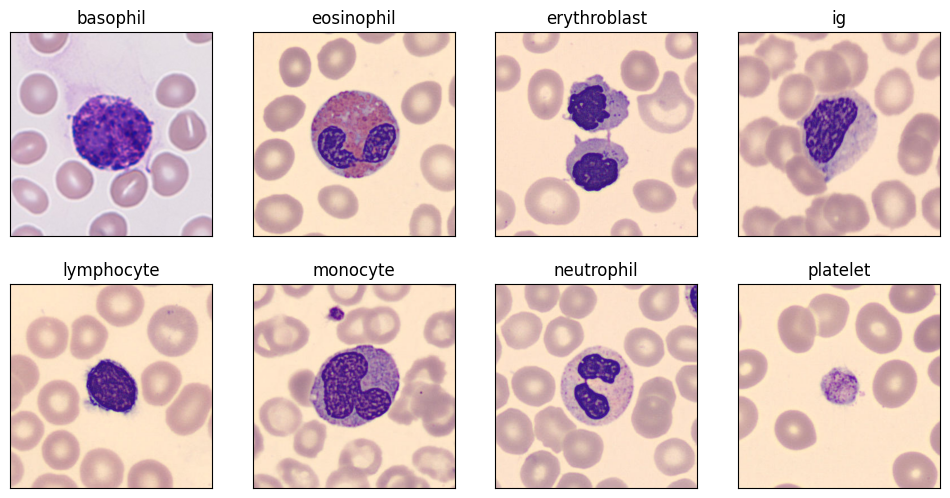

In [ ]:
class_names = ['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']

fig, ax = plt.subplots(2, 4, figsize=(12, 6))
ax = ax.flat

for i, class_name in enumerate(class_names):
    class_path = os.path.join(dataset_dir, class_name)
    image_files = [os.path.join(class_path, file) for file in os.listdir(class_path) if file.endswith('.jpg')]

    image = PIL.Image.open(image_files[0])
    ax[i].set_title(class_name)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].imshow(image)

plt.show()

###Transform Dataset into TF dataset

In [ ]:
dataset = image_dataset_from_directory(dataset_dir, batch_size=16, image_size=(244, 244))

Found 17092 files belonging to 8 classes.


###Splitting Dataset

In [ ]:
train_dataset = image_dataset_from_directory(
    dataset_dir,
    batch_size=16,
    image_size=(244, 244),
    validation_split=0.2,
    subset="training",
    shuffle=False
)

val_dataset = image_dataset_from_directory(
    dataset_dir,
    batch_size=16,
    image_size=(244, 244),
    validation_split=0.2,
    subset="validation",
    shuffle=False
)


Found 17092 files belonging to 8 classes.
Using 13674 files for training.
Found 17092 files belonging to 8 classes.
Using 3418 files for validation.


###Image Augmentation

In [ ]:
augmented = keras.Sequential([
    keras.layers.RandomFlip("horizontal_and_vertical"),
    keras.layers.RandomRotation(0.2)
    ])

##First Model : ResNet50 with CNN

###Dataset Preparation for ResNet50

In [ ]:
train_dataset_resnet = train_dataset.map(lambda X, y: (preprocess_input(X), y)).prefetch(tf.data.AUTOTUNE)
val_dataset_resnet = val_dataset.map(lambda X, y: (preprocess_input(X), y)).prefetch(tf.data.AUTOTUNE)

###Model Architecture

In [ ]:
IMG_HEIGHT = 244
IMG_WIDTH = 244

feature_extraction_layer = ResNet50(include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
feature_extraction_layer.trainable = True

model = Sequential([
    augmented,
    feature_extraction_layer,
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.2),
    Flatten(),
    Dense(8, activation="softmax")
])

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["accuracy"]
)
model.build(input_shape=(None, IMG_HEIGHT, IMG_WIDTH, 3))

model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 244, 244, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 conv2d (Conv2D)             (None, 6, 6, 64)          1179712   
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 64)          0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 3, 3, 64)          0         
                                                                 
 flatten (Flatten)           (None, 576)               

###Callback

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if((logs.get('accuracy') > 0.97) and (logs.get('val_accuracy') > 0.97)):
      self.model.stop_training = True
      print("\nThe accuracy of the training set and the validation set has reached > 97%!")
callbacks = myCallback()


###Training

In [ ]:
history = model.fit(train_dataset_resnet,
                      validation_data=val_dataset_resnet,
                      epochs=100,
                      callbacks=[callbacks])

Epoch 1/100
855/855 [==============================] - 317s 318ms/step - loss: 0.2740 - accuracy: 0.9190 - val_loss: 0.1549 - val_accuracy: 0.9493
Epoch 2/100
855/855 [==============================] - 272s 318ms/step - loss: 0.1120 - accuracy: 0.9661 - val_loss: 0.1183 - val_accuracy: 0.9678
Epoch 3/100
855/855 [==============================] - ETA: 0s - loss: 0.0977 - accuracy: 0.9706
The accuracy of the training set and the validation set has reached > 97%!
855/855 [==============================] - 264s 308ms/step - loss: 0.0977 - accuracy: 0.9706 - val_loss: 0.0714 - val_accuracy: 0.9809


###Plotting Accuracy and Loss

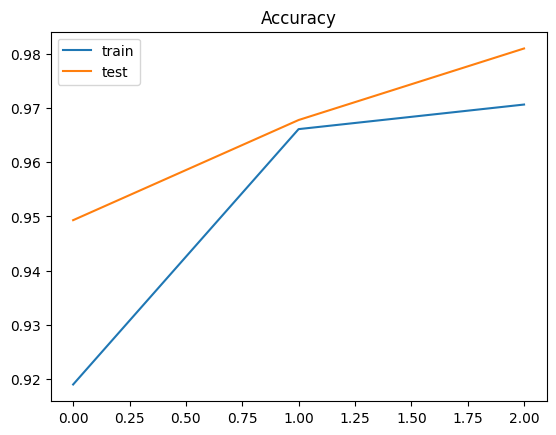

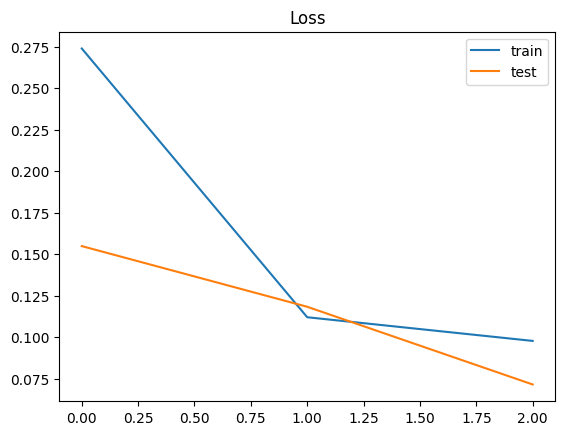

In [ ]:
# Plotting accuracy and val_accuracy
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

# Plotting loss and val_loss
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

###Model Evaluation

In [ ]:
results = model.evaluate(val_dataset_resnet, verbose=0)
print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.07486
Test Accuracy: 98.01%


In [ ]:
y_true = np.concatenate([label.numpy() if label.ndim > 0 else np.expand_dims(label.numpy(), axis=0) for _, label in val_dataset_resnet.unbatch()])

Y_pred = model.predict(val_dataset_resnet)
y_pred = np.argmax(Y_pred, axis=1)

target_report = ['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']

print(classification_report(y_true, y_pred, target_names=target_report))

214/214 [==============================] - 36s 95ms/step
              precision    recall  f1-score   support

    basophil       0.05      0.05      0.05       238
  eosinophil       0.21      0.20      0.21       656
erythroblast       0.10      0.10      0.10       301
          ig       0.19      0.19      0.19       586
  lymphocyte       0.08      0.08      0.08       240
    monocyte       0.08      0.08      0.08       270
  neutrophil       0.20      0.20      0.20       651
    platelet       0.14      0.14      0.14       470

    accuracy                           0.15      3412
   macro avg       0.13      0.13      0.13      3412
weighted avg       0.15      0.15      0.15      3412



Saving images.jpg to images (3).jpg
1/1 [==============================] - 0s 57ms/step
Predicted class: eosinophil


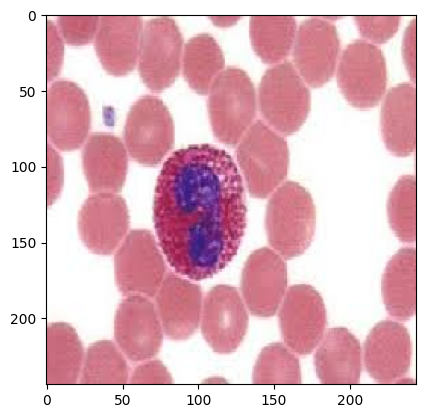

In [ ]:
%matplotlib inline

upload = files.upload()

for fn in upload.keys():


  path = fn
  img = image.load_img(path, target_size=(244,244))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=16)

  predicted_class_index = np.argmax(classes)

  target_report = ['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']
  predicted_class = target_report[predicted_class_index]

  print(f'Predicted class: {predicted_class}')

##Second Model : CNN

###Model Architecture

In [ ]:
IMG_HEIGHT = 244
IMG_WIDTH = 244


modelv2 = keras.Sequential([
    augmented,
    Conv2D(64, (3,3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.4),
    Flatten(),
    Dense(8, activation="softmax")
])

modelv2.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["accuracy"]
)

###Training Process

In [ ]:
historyv2 = modelv2.fit(train_dataset,
                      validation_data=val_dataset,
                      epochs=100,
                      callbacks=[callbacks])

Epoch 1/100
  6/855 [..............................] - ETA: 1:31 - loss: 94.3175 - accuracy: 0.1458 

855/855 [==============================] - 124s 136ms/step - loss: 1.8631 - accuracy: 0.7721 - val_loss: 0.3258 - val_accuracy: 0.8919
Epoch 2/100
855/855 [==============================] - 118s 137ms/step - loss: 0.3673 - accuracy: 0.8778 - val_loss: 0.2785 - val_accuracy: 0.9083
Epoch 3/100
855/855 [==============================] - 117s 137ms/step - loss: 0.2965 - accuracy: 0.9046 - val_loss: 0.2327 - val_accuracy: 0.9294
Epoch 4/100
855/855 [==============================] - 117s 136ms/step - loss: 0.2492 - accuracy: 0.9191 - val_loss: 0.1610 - val_accuracy: 0.9525
Epoch 5/100
855/855 [==============================] - 117s 136ms/step - loss: 0.2222 - accuracy: 0.9296 - val_loss: 0.2562 - val_accuracy: 0.9179
Epoch 6/100
855/855 [==============================] - 117s 137ms/step - loss: 0.1901 - accuracy: 0.9360 - val_loss: 0.1466 - val_accuracy: 0.9502
Epoch 7/100
855/855 [==============================] - 117s 136ms/step - loss: 0.1755 - accuracy: 0.9442 - val_loss: 0.2911 - val_

###Plotting Accuracy and Loss

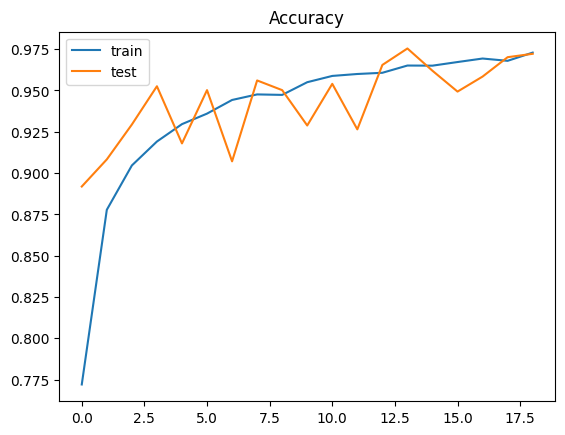

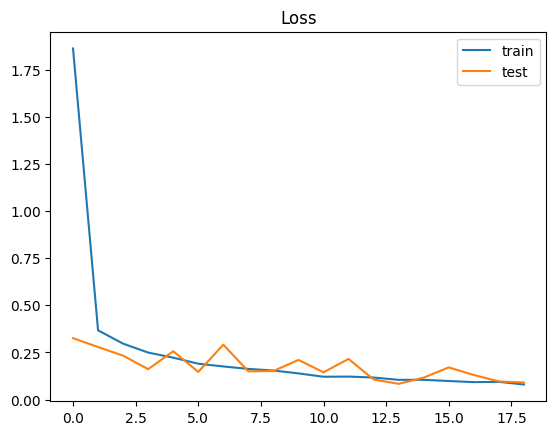

In [ ]:
# Plotting accuracy and val_accuracy
plt.title('Accuracy')
plt.plot(historyv2.history['accuracy'], label='train')
plt.plot(historyv2.history['val_accuracy'], label='test')
plt.legend()
plt.show();

# Plotting loss and val_loss
plt.title('Loss')
plt.plot(historyv2.history['loss'], label='train')
plt.plot(historyv2.history['val_loss'], label='test')
plt.legend()
plt.show();

###Summary:
1. The first model using ResNet50 combined with CNN has 98% accuracy. There is no problem encountered with training process but needing spesific dataset preparation for ResNet50 input.
2. The second model needs longer time for training. Also the validation accuracy and loss has some fluctuation value but the curve is generally increases along with training accuracy.

##TF Lite Converter

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [ ]:
with tf.io.gfile.GFile('model__v1.tflite', 'wb') as f:
  f.write(tflite_model)